## The Business Case
Machine learning’s numerous implications include improving business decision-making. This project provides a practical illustration of this use case, focusing on predicting the likelihood of a student registered for a free plan purchasing a subscription on the platform. 

The assumption is that the decision is based on students’ activities on the platform—viewing lectures and participating in exams.

The project is inspired by an initiative 365 had in 2022 to predict student purchases before their Black Friday campaign. They wanted to create a list of students with high likelihood to purchase their paid plan and target them with unique ads on social media i.e. targetted marketing efforts. 

However, this was no easy task due to the extreme imbalance of the data—the number of students who had never purchased a subscription was much higher than the number of students who had. The primary reason for that was the free campaign run before the Black Friday one, where the platform was unlocked for free to all 365 students. Such class imbalance combined with humans’ unpredictable behavior makes it challenging to predict student purchases.

## The Data
The data consists of seven columns used as predictor variables and one as a target variable (the purchased column). The target variable is a binary column where 0 indicates a student who hasn’t bought a subscription and 1 represents a student who has. All predictor variables (except student_country) store metrics related to student behavior recorded between the following:

- Registration date and the last available date in our dataset: Oct 20, 2022, when the purchased column equals 0
- Registration date and their first purchase when the purchased column equals 1

In this way, we study students’ behavior only during their free-plan period on the platform.

# Importing the relevant libraries

In [238]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Data Preprocessing

### Importing the Database

In [4]:
data=pd.read_csv('/Users/tasneem.kapadia/Downloads/project-files-machine-learning-for-user-classification/ml_datasource.csv')

In [5]:
data.head()

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_started,practice_exams_passed,minutes_spent_on_exams,purchased
0,US,288,358.1,1,2,2,15.81,0
1,SG,260,1.7,1,1,0,16.00,0
2,TR,260,22.4,1,1,0,0.93,0
3,KE,259,18.8,1,1,1,14.63,0
4,IN,259,118.0,2,2,1,16.48,0


In [6]:
data.shape

(17761, 8)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17761 entries, 0 to 17760
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   student_country         17752 non-null  object 
 1   days_on_platform        17761 non-null  int64  
 2   minutes_watched         17761 non-null  float64
 3   courses_started         17761 non-null  int64  
 4   practice_exams_started  17761 non-null  int64  
 5   practice_exams_passed   17761 non-null  int64  
 6   minutes_spent_on_exams  17761 non-null  float64
 7   purchased               17761 non-null  int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 1.1+ MB


### Removing Outliers

<Axes: xlabel='purchased', ylabel='count'>

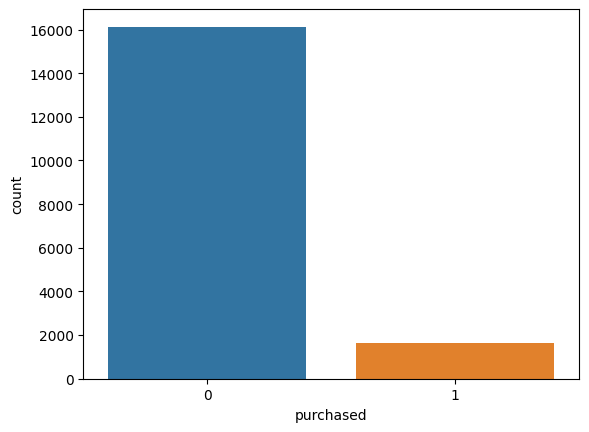

In [8]:
# Analysing the data
sns.countplot(data=data, x='purchased')

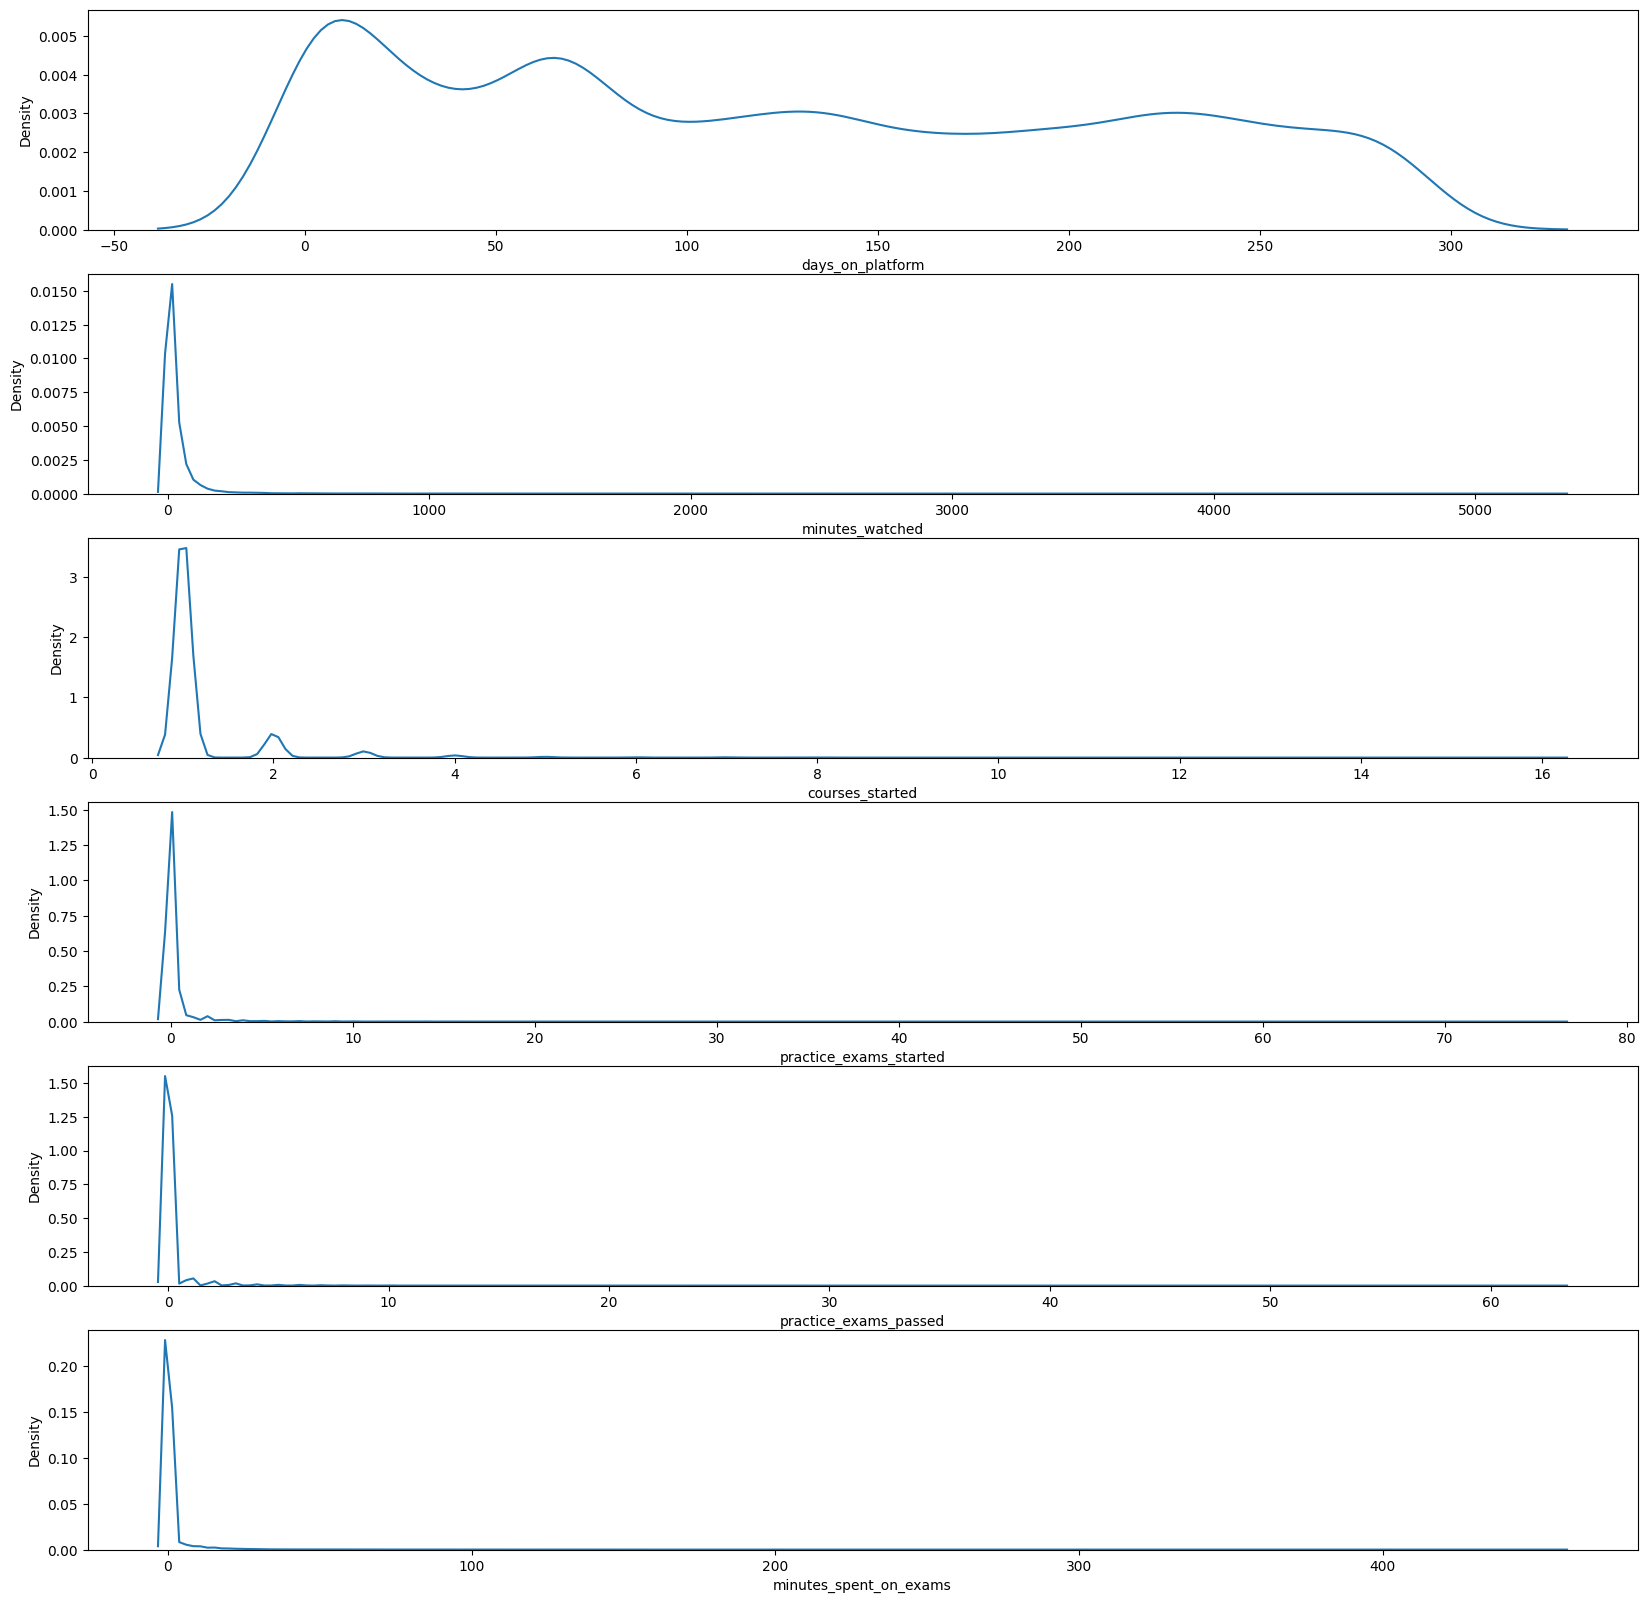

In [21]:
plt.figure(figsize=(20,20))
plt.subplot(6,1,1)
sns.kdeplot(data=data, x='days_on_platform')
plt.subplot(6,1,2)
sns.kdeplot(data=data, x='minutes_watched')
plt.subplot(6,1,3)
sns.kdeplot(data=data, x='courses_started')
plt.subplot(6,1,4)
sns.kdeplot(data=data, x='practice_exams_started')
plt.subplot(6,1,5)
sns.kdeplot(data=data, x='practice_exams_passed')
plt.subplot(6,1,6)
sns.kdeplot(data=data, x='minutes_spent_on_exams');

The data is highly skewed. Since this data largely considers students who had access to the free plan, the data indicates that while most students have attempted 2-3 courses, there were some students who took maximum advantage of the free plan to complete as many courses as possible.


In [38]:
data.groupby('purchased')[['minutes_watched','courses_started', 'practice_exams_started']].agg(['mean', 'max'])

minutes_watched         courses_started     practice_exams_started   
                     mean     max            mean max                   mean   
purchased                                                                      
0               27.684582  5312.3        1.188035  16               0.263794  \
1               64.691110  1036.2        1.279583   9               0.416309   

               
          max  
purchased      
0          76  
1          16

In [42]:
data.describe()

,days_on_platform,minutes_watched,courses_started,practice_exams_started,practice_exams_passed,minutes_spent_on_exams,purchased
count,17761.000000,17761.000000,17761.000000,17761.000000,17761.000000,17761.000000,17761.000000
mean,123.205112,31.082906,1.196442,0.277800,0.176341,1.242772,0.091830
std,90.675102,90.593660,0.646788,1.659998,1.099900,7.755386,0.288795
min,0.000000,0.100000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,42.000000,1.100000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,113.000000,6.800000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,204.000000,34.300000,1.000000,0.000000,0.000000,0.000000,0.000000
max,292.000000,5312.300000,16.000000,76.000000,63.000000,457.410000,1.000000


Selecting threshold values to reduce the skewness
- Minutes watched larger than 1,000
- Number of courses surpassing 10
- Number of practice exams started higher than 10
- Minutes spent on exams going beyond 40 minutes

We could’ve lowered the cutoffs and reduced the skewness of the data even more. Still, we should be careful with removing too many datapoints—as a rule of thumb, we should remove no more than 5%. Additionally, we should remember that the data is heavily imbalanced, and removing too many datapoints from the minority class would lead to inaccurate predictions.

In [55]:
data=data[data['minutes_watched']<1000]
data=data[data['courses_started']<10]
data=data[data['practice_exams_started']<10]
data=data[data['minutes_spent_on_exams']<40]
data.shape

(17614, 8)

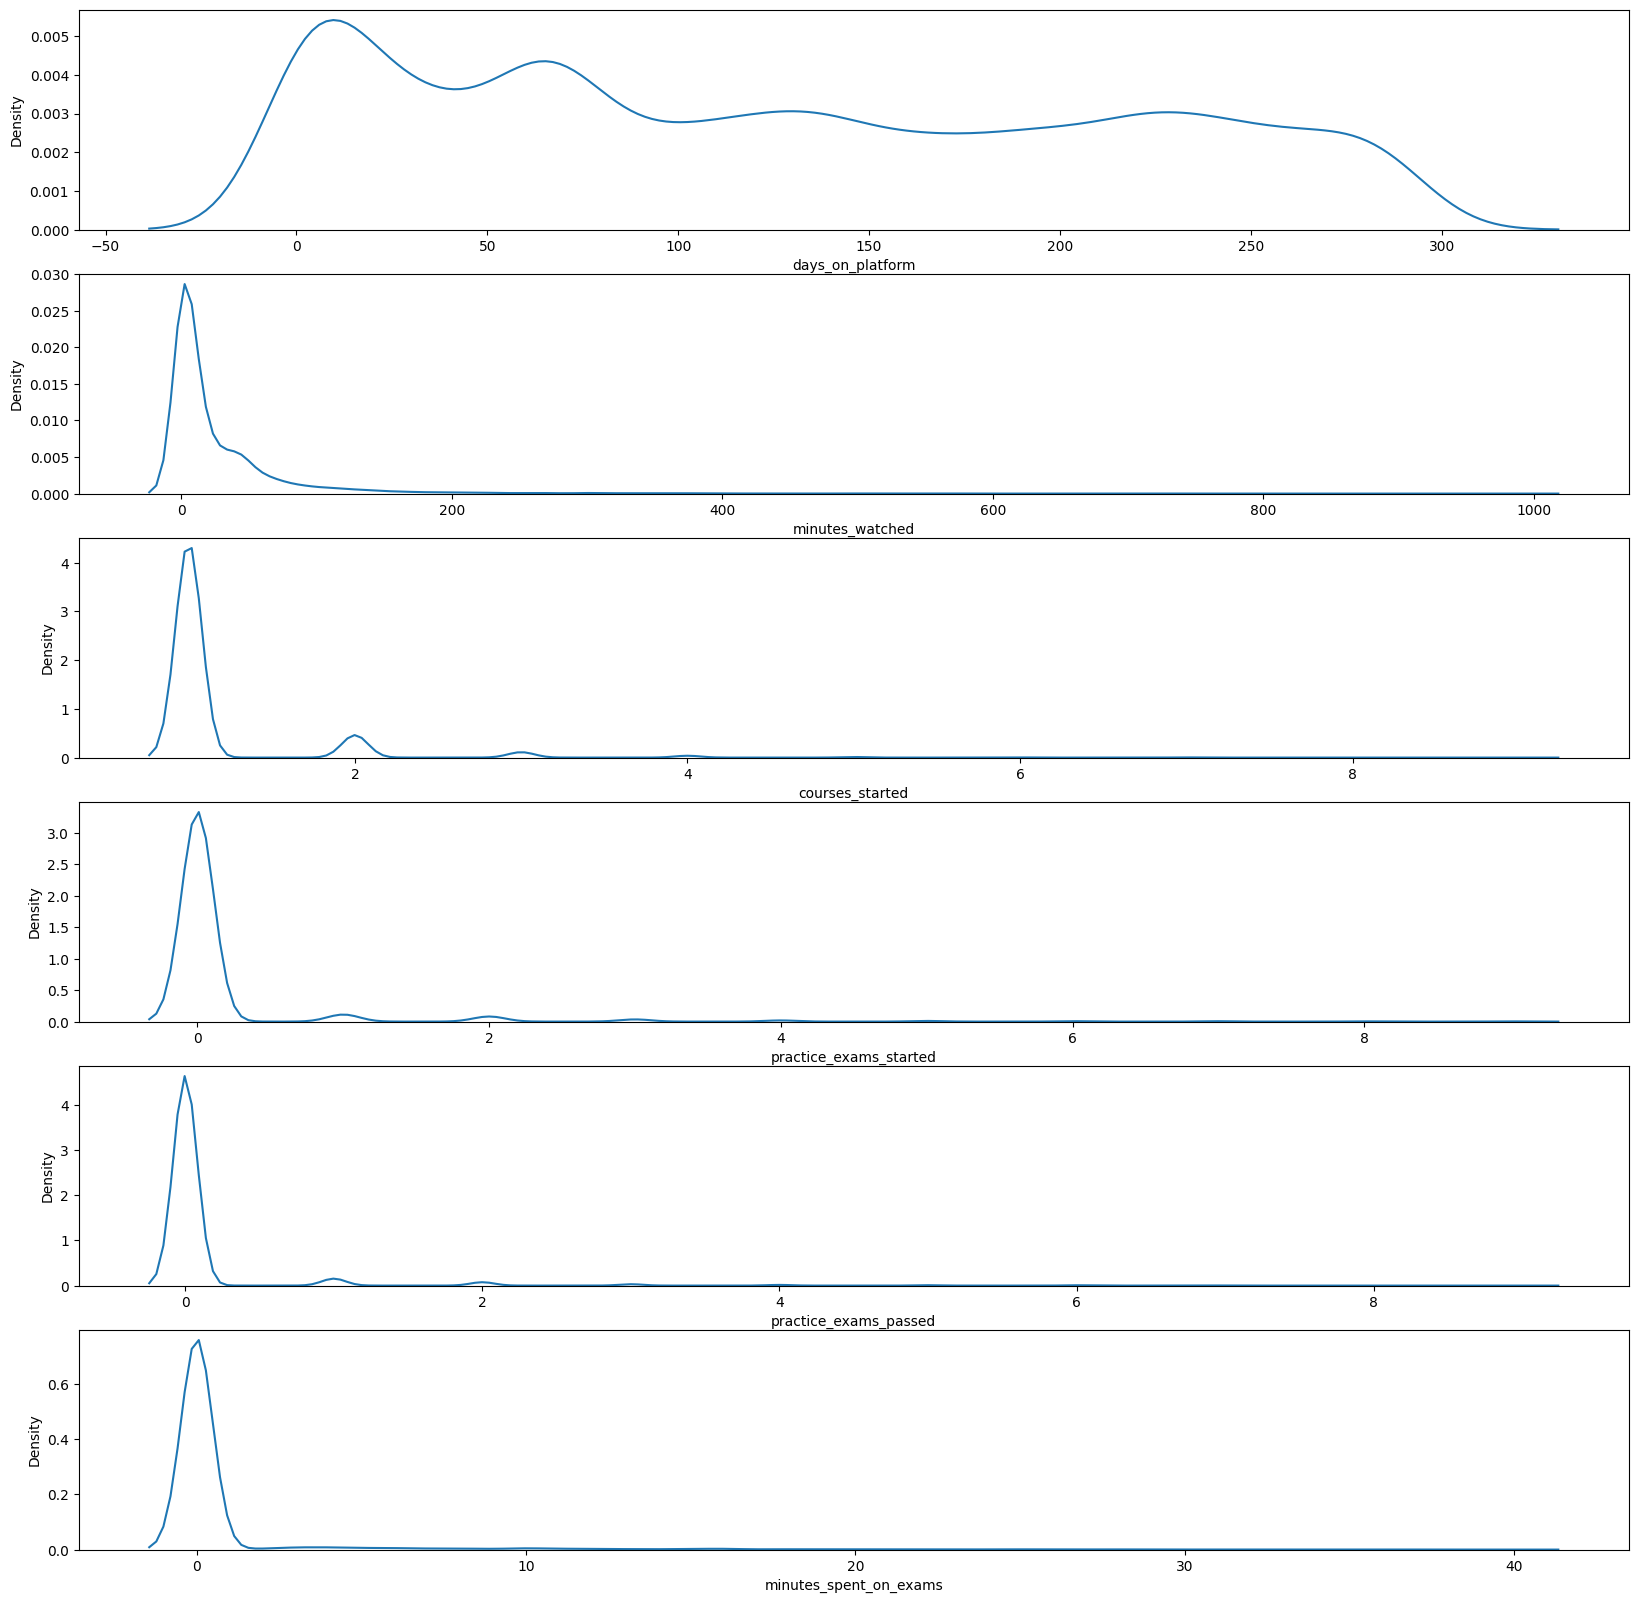

In [57]:
plt.figure(figsize=(20,20))
plt.subplot(6,1,1)
sns.kdeplot(data=data, x='days_on_platform')
plt.subplot(6,1,2)
sns.kdeplot(data=data, x='minutes_watched')
plt.subplot(6,1,3)
sns.kdeplot(data=data, x='courses_started')
plt.subplot(6,1,4)
sns.kdeplot(data=data, x='practice_exams_started')
plt.subplot(6,1,5)
sns.kdeplot(data=data, x='practice_exams_passed')
plt.subplot(6,1,6)
sns.kdeplot(data=data, x='minutes_spent_on_exams');

### Checking for Multicollinearity

<Axes: >

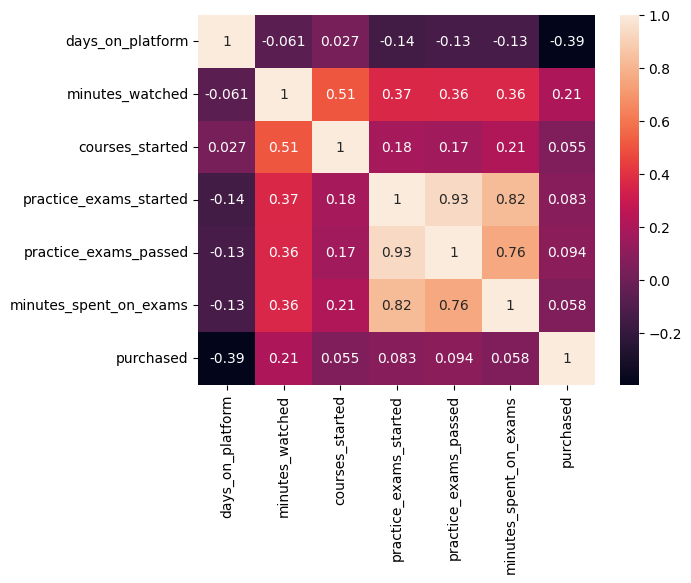

In [56]:
corr=data.select_dtypes(include='number').corr()
sns.heatmap(corr, annot=True)

The term ‘multicollinearity’ refers to a situation where two or more independent variables in a regression model are highly linearly related. Such a problem can make it difficult to determine the individual effect of predictors on the dependent variable and can lead to unstable coefficient estimates.

Although this is a classification project rather than a regression problem, removing highly-related feature variables is still important. 

A logistic regression model, for example, assumes its predictors are independent. Moreover, dealing with multicollinearity helps reduce the dimensionality (the number of feature variables) of a problem; high dimensionality is an issue that the k-nearest neighbors model, for instance, could suffer from. Decision trees and random forests are seldom affected by multicollinearity.

The Variance Inflation Factor (VIF) is a measure used to detect the presence of multicollinearity in a dataset. A value of 1 indicates that the features are not correlated, while a value greater than 1 suggests the presence of a correlation. As a rule of thumb, a variable with a VIF value higher than 5 indicates problematic multicollinearity.
Such features are redundant with others in the dataset and its removal will help reduce multicollinearity as well as dimensions. 

In [72]:
# Import functions
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Get variables for which to compute VIF and add intercept term
X = data[['days_on_platform','minutes_watched','courses_started','practice_exams_started','practice_exams_passed','minutes_spent_on_exams']]
X['intercept'] = 1

# Compute and view VIF
vif = pd.DataFrame()

vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# View results using print
print(vif.sort_values(by='VIF', ascending=False))

                variables        VIF
3  practice_exams_started  10.003004
4   practice_exams_passed   7.713868
6               intercept   7.558636
5  minutes_spent_on_exams   3.166480
1         minutes_watched   1.528343
2         courses_started   1.364496
0        days_on_platform   1.026410


/var/folders/8w/c727zz55285fh2d8ym9_mk_n3jhw8z/T/ipykernel_47288/1367946243.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


'practice_exams_started' has the high VIF numbers, i.e. its presecence would cause bias in the data set. Recalculating the VIF after dropping 'practice_exams_passed'

In [73]:
X = data[['days_on_platform','minutes_watched','courses_started','practice_exams_passed','minutes_spent_on_exams']]
X['intercept'] = 1

# Compute and view VIF
vif = pd.DataFrame()

vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# View results using print
print(vif.sort_values(by='VIF', ascending=False))

                variables       VIF
5               intercept  7.543216
3   practice_exams_passed  2.460786
4  minutes_spent_on_exams  2.460503
1         minutes_watched  1.527473
2         courses_started  1.364480
0        days_on_platform  1.024161


/var/folders/8w/c727zz55285fh2d8ym9_mk_n3jhw8z/T/ipykernel_47288/2552790924.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Removing 'practice_exams_started' has reduced the multicollinearity and will help with the results of our analysis

In [75]:
data_new= data.drop(columns=['practice_exams_started'])

<Axes: >

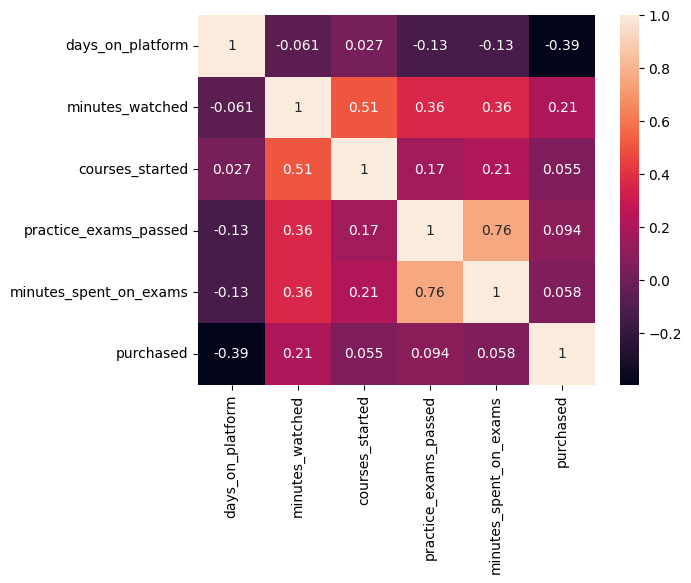

In [83]:
corr=data_new.select_dtypes(include='number').corr()
sns.heatmap(corr, annot=True)

### Dealing with NaN Values

In [76]:
data_new.isna().sum()

student_country           8
days_on_platform          0
minutes_watched           0
courses_started           0
practice_exams_passed     0
minutes_spent_on_exams    0
purchased                 0
dtype: int64

In [77]:
data_new.loc[data_new['student_country'].isna()]

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams,purchased
311,NaN,88,58.1,1,2,11.20,1
337,NaN,86,43.0,1,2,12.96,0
556,NaN,121,241.9,2,3,21.29,0
806,NaN,64,86.4,1,2,4.98,0
1097,NaN,72,67.5,1,1,6.27,0
12363,NaN,84,6.2,1,0,0.00,0
12633,NaN,78,3.0,1,0,0.00,0
16946,NaN,11,8.2,1,0,0.00,0


As it turns out, the string NA in 365’s database refers to the country code of Namibia. But after importing the CSV file into a pandas DataFrame, this country code has been translated to NaN. We will fill the NaNs with the country code 'NAM'



In [81]:
data_new['student_country'].fillna('NAM', inplace=True)

In [82]:
data_new.isna().sum()

student_country           0
days_on_platform          0
minutes_watched           0
courses_started           0
practice_exams_passed     0
minutes_spent_on_exams    0
purchased                 0
dtype: int64

### Splitting the Data

First, create your inputs and target variables for your machine learning model. You can achieve this by using, for example, the drop() function to remove the purchased column from the inputs.
Import the sklearn.model_selection library at the beginning of the notebook. To split your data into training and testing sets, use the train_test_split function which shuffles the dataset and splits it into training and testing sets.
Inside the train_test_split function, you'll need to specify the following:
Your input data
Target data
The proportion of the dataset to include in the testing set
Random seed for reproducibility
The decision to stratify the split
The train_test_split function will return four values: the training data, testing data, training labels, and testing labels. Assign these outputs to x_train, x_test, y_train, and y_test, respectively.

In [84]:
from sklearn.model_selection import train_test_split
X=data_new.drop(columns='purchased')
y= data_new.purchased

In [245]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.20, random_state=365, stratify=y)

In [246]:
X_train.shape, X_test.shape

((14091, 6), (3523, 6))

### Encoding the Data

One of our data points, country, is still in text format. We either have to omit it from the analysis, since most models use numerical data, or we transform it. We will be using OrdinalEncoder here, the input to this transformer should be an array-like of integers or strings, denoting the values taken on by categorical (discrete) features. The features are converted to ordinal integers. This results in a single column of integers (0 to n_categories - 1) per feature.

Why Ordinal over the others?
- LabelEncoder: Encodes the target variable to values between 0- (n-1), our target is already encoded
- OneHotEncoding: Converts each category to a column and adds 1 or 0 as per the category, this is good only for low to medium cardinality.
- TargetEncoder: Encodes the feature using a supervised signal in a classification or regression pipeline.This encoding is typically suitable for high cardinality categorical variables.

In [247]:
from sklearn.preprocessing import OrdinalEncoder
ord_enc= OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=170)
X_train['student_country_enc'] = ord_enc.fit_transform(X_train['student_country'].to_numpy().reshape(-1, 1));
X_train.drop(columns='student_country', inplace=True)

In [248]:
X_test['student_country_enc'] = ord_enc.transform(X_test['student_country'].to_numpy().reshape(-1, 1));
X_test.drop(columns='student_country', inplace=True)

During the transformation procedure, we get an error message reading that unknown categories from the student_country column are found during the transformation. The encoder doesn’t know how to transform values from the test data that it hasn’t previously seen in the training data.

To manage that, we modified the OrdinalEncoder instance to assign a chosen value to all country codes that are not present in the training data but present in the test data.

# Creating a Logistic Regression Model

In [249]:
from sklearn.linear_model import LogisticRegression
log_reg= LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred=log_reg.predict(X_test)

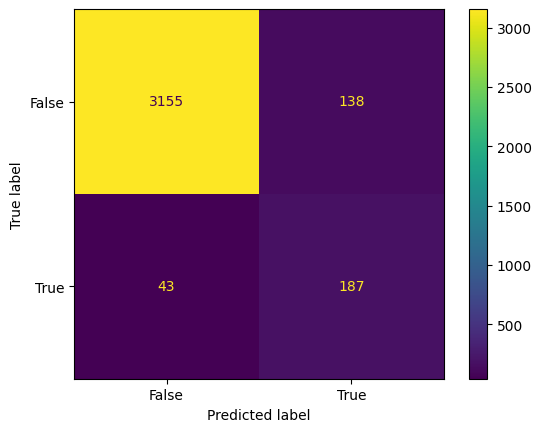

In [250]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix=confusion_matrix(y_pred, y_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show();

In [313]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.156115
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:              purchased   No. Observations:                14091
Model:                          Logit   Df Residuals:                    14085
Method:                           MLE   Df Model:                            5
Date:                Fri, 10 Nov 2023   Pseudo R-squ.:                  0.4922
Time:                        12:03:30   Log-Likelihood:                -2199.8
converged:                       True   LL-Null:                       -4331.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
days_on_platform          -0.0664      0.002    -32.245      0.000      -0.070     

In [315]:
result.params

days_on_platform         -0.066406
minutes_watched           0.013897
courses_started          -0.279913
practice_exams_passed     0.153330
minutes_spent_on_exams   -0.074795
student_country_enc       0.002370
dtype: float64

practise_exams_passed has a high p-value, indicating that there is no correlation between the dependant variable and the the null hypothesis is accepted. If we remove this column, the results are:

In [318]:
logit_model=sm.Logit(y_train,X_train.drop(columns='practice_exams_passed'))
result=logit_model.fit()
print(result.summary())
print(result.params)

Optimization terminated successfully.
         Current function value: 0.156254
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:              purchased   No. Observations:                14091
Model:                          Logit   Df Residuals:                    14086
Method:                           MLE   Df Model:                            4
Date:                Fri, 10 Nov 2023   Pseudo R-squ.:                  0.4917
Time:                        16:09:31   Log-Likelihood:                -2201.8
converged:                       True   LL-Null:                       -4331.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
days_on_platform          -0.0664      0.002    -32.246      0.000      -0.070     

In [251]:
from sklearn.metrics import accuracy_score, classification_report
print('Model Accuracy:', accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

Model Accuracy: 0.94862333238717
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      3198
           1       0.81      0.58      0.67       325

    accuracy                           0.95      3523
   macro avg       0.89      0.78      0.82      3523
weighted avg       0.94      0.95      0.94      3523



# Creating a K-Nearest Neighbors Model

In [252]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

parameters= {'n_neighbors': range(1,51),
            'weights': ['uniform', 'distance']}

neighbours=KNeighborsClassifier()
grid_search_knn=GridSearchCV(neighbours, param_grid= parameters,scoring='accuracy')

In [253]:
grid_search_knn.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 51),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [254]:
grid_search_knn.best_params_
# grid_search_knn.best_score_

{'n_neighbors': 5, 'weights': 'uniform'}

In [255]:
neighbours_cv=KNeighborsClassifier(n_neighbors=9, weights='uniform')
neighbours_cv.fit(X_train, y_train)
y_pred_knn=neighbours_cv.predict(X_test)

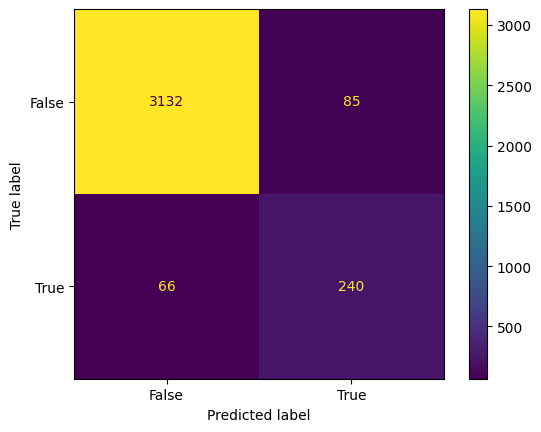

In [323]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
conf_matrix=confusion_matrix(pd.Series(y_pred_knn), y_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
cm_display.plot()
plt.show();

In [324]:
print('Model Accuracy:', accuracy_score(y_test,y_pred_knn))
print(classification_report(y_test,y_pred_knn, target_names=['Not enrolled', 'Enrolled']))

Model Accuracy: 0.9571388021572523
              precision    recall  f1-score   support

Not enrolled       0.97      0.98      0.98      3198
    Enrolled       0.78      0.74      0.76       325

    accuracy                           0.96      3523
   macro avg       0.88      0.86      0.87      3523
weighted avg       0.96      0.96      0.96      3523



# Creating a Support Vector Machines Model

## Scaling the data:

While SVM does not require scaling,it is highly recommended, as it can significantly improve model performance and convergence speed. 

MinMaxScaler preserves the shape of the original distribution. It doesn't meaningfully change the information embedded in the original data nor does it reduce the importance of outliers. The default range for the feature returned by MinMaxScaler is 0 to 1.

Since our data is skewed and does not follow a normal distribution, we want to preserve the effects of outliers and find a way to allow the model to converge faster.

In [258]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
scale=MinMaxScaler(feature_range=(-1,1))
X_train_scaled=scale.fit_transform(X_train)
X_test_scaled=scale.transform(X_test)

In [259]:
svm_parameters={'C':range(1,11),
               'kernel':['linear', 'poly', 'rbf'],
               'gamma':['auto', 'scale']}

In [260]:
svc=SVC()
grid_svm=GridSearchCV(svc, param_grid=svm_parameters, scoring='accuracy')
grid_svm.fit(X_train_scaled, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': range(1, 11), 'gamma': ['auto', 'scale'],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='accuracy')

In [261]:
grid_svm.best_params_

{'C': 10, 'gamma': 'scale', 'kernel': 'poly'}

In [262]:
svm_cv=SVC(C=5, gamma='scale', kernel='poly')
svm_cv.fit(X_train_scaled, y_train)
y_pred_svc=svm_cv.predict(X_test_scaled)

In [263]:
print('Model Accuracy:', accuracy_score(y_test,y_pred_svc))
print(classification_report(y_test,y_pred_svc))

Model Accuracy: 0.9540164632415555
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3198
           1       0.80      0.66      0.73       325

    accuracy                           0.95      3523
   macro avg       0.88      0.82      0.85      3523
weighted avg       0.95      0.95      0.95      3523



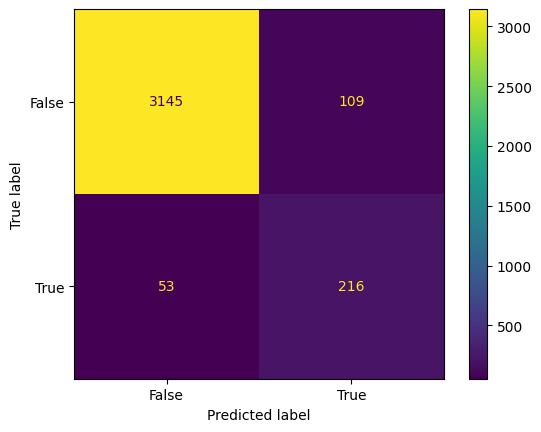

In [264]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix=confusion_matrix(pd.Series(y_pred_svc), y_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
cm_display.plot()
plt.show();

# Creating a Decision Trees Model

In [267]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

dec_tree_parameters={'ccp_alpha':[0,0.001, 0.002, 0.003, 0.004, 0.005],
               'criterion' : ["gini", "entropy"]
              }
dec_tree=DecisionTreeClassifier()
grid_dec=GridSearchCV(dec_tree, param_grid=dec_tree_parameters, scoring='accuracy')
grid_dec.fit(X_train, y_train)
grid_dec.best_params_

{'ccp_alpha': 0.002, 'criterion': 'entropy'}

In [272]:
dec_cv=DecisionTreeClassifier(ccp_alpha=0.002)
dec_cv.fit(X_train, y_train)
y_pred_dec=dec_cv.predict(X_test)
print('Model Accuracy:', accuracy_score(y_test,y_pred_dec))
print(classification_report(y_test,y_pred_dec))

Model Accuracy: 0.9605449900652853
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3198
           1       0.88      0.66      0.76       325

    accuracy                           0.96      3523
   macro avg       0.92      0.83      0.87      3523
weighted avg       0.96      0.96      0.96      3523



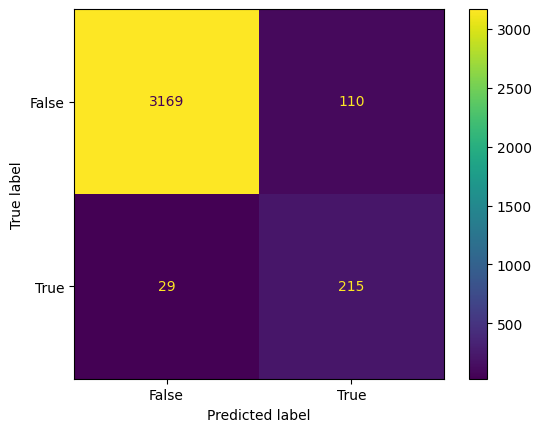

In [273]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix=confusion_matrix(pd.Series(y_pred_dec), y_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
cm_display.plot()
plt.show();

<BarContainer object of 6 artists>

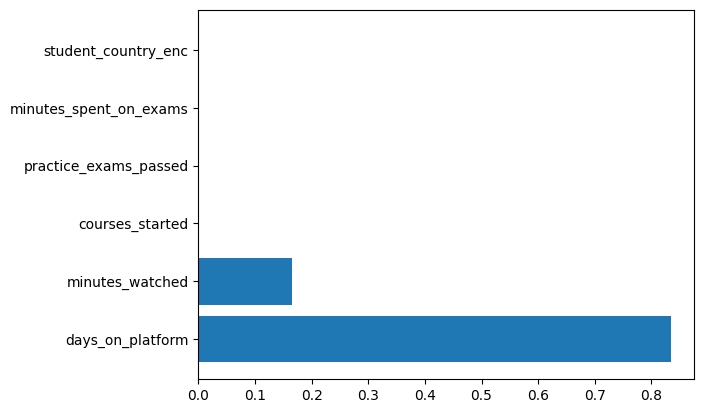

In [322]:
plt.barh( dec_cv.feature_names_in_, dec_cv.feature_importances_,)

### Plotting the tree:

$filled=True$ It colors the boxes representing the decision nodes. The color tone corresponds to the purity of the node, with lighter tones indicating less pure nodes.

$feature names$ Using the list of column names (in the order they were used for training) with this parameter will label each decision split in the tree with the corresponding feature name giving better understanding of the tree.

$class names$  This parameter is a list of strings representing the class labels. This will label each leaf node with the corresponding class label.

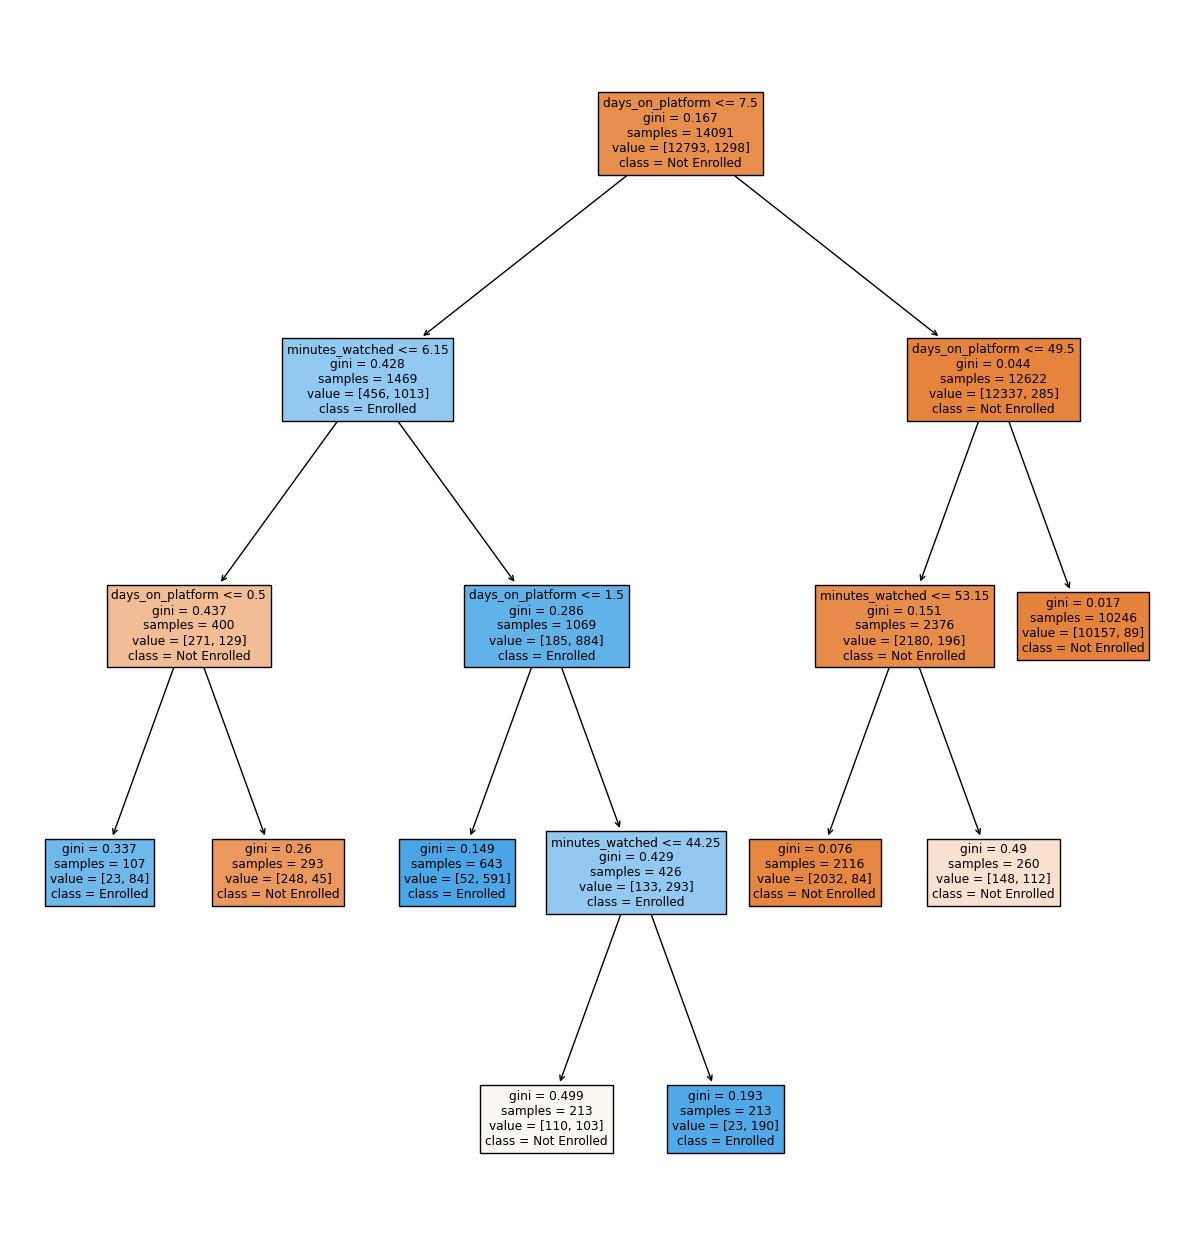

In [283]:
plt.figure(figsize=(15,16))
plot_tree(dec_cv, filled=True, feature_names=list(dec_cv.feature_names_in_), class_names=['Not Enrolled', 'Enrolled']);

# Creating a Random Forests Model

In [291]:
from sklearn.ensemble import RandomForestClassifier

rfm_parameters={'ccp_alpha':[0,0.001, 0.002, 0.003, 0.004, 0.005],
               'criterion' : ["gini", "entropy"]
              }
rfm=RandomForestClassifier()
grid_rfm=GridSearchCV(rfm, param_grid=rfm_parameters, scoring='accuracy')
grid_rfm.fit(X_train, y_train)
grid_rfm.best_params_

{'ccp_alpha': 0.001, 'criterion': 'entropy'}

In [308]:
rfm_cv=DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy')
rfm_cv.fit(X_train, y_train)
y_pred_rfm=dec_cv.predict(X_test)
print('Model Accuracy:', accuracy_score(y_test,y_pred_rfm))
print(classification_report(y_test,y_pred_rfm))

Model Accuracy: 0.9605449900652853
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3198
           1       0.88      0.66      0.76       325

    accuracy                           0.96      3523
   macro avg       0.92      0.83      0.87      3523
weighted avg       0.96      0.96      0.96      3523



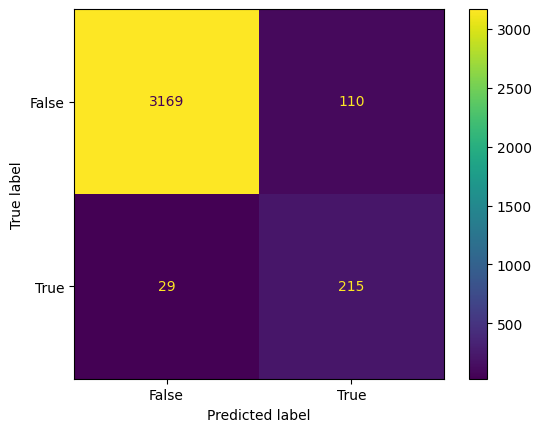

In [309]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix=confusion_matrix(pd.Series(y_pred_rfm), y_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
cm_display.plot()
plt.show();

## RESULTS AND INFERENCES:

In [311]:
#Combining the results
pd.DataFrame(index=['Logistic Regression','KNN', 'SVM', 'Random Forest'], 
             columns=['Accuracy score'],
             data={
                  accuracy_score(y_test,y_pred),
                  accuracy_score(y_test,y_pred_knn),
                  accuracy_score(y_test,y_pred_svc),
#                   accuracy_score(y_test,y_pred_dec),
                  accuracy_score(y_test,y_pred_rfm)
             } )

,Accuracy score
Logistic Regression,0.948623
KNN,0.957139
SVM,0.954016
Random Forest,0.960545


1. What is the LLR (Log Likelihood Ratio) p-value in the summary of the logistic regression model, and what does it tell us?

p-value helps us decide whether there is a relationship between two variables or not. The smaller the p-value the more confident you are about the existence of relationship between the two variables.

The regression p value for each independent variable tests the null hypothesis, that the variable has no correlation with the dependent variable. If there is no correlation, there is no association between the changes in the independent variable and the shifts in the dependent variable. In other words, there is insufficient evidence to conclude that there is an effect at the population level.

If the p-value for a variable is less than the significance level (0.05 as standard practise), the sample data provides enough evidence to reject the null hypothesis for the entire population. Your data favor the hypothesis that there is a non-zero correlation. Changes in the independent variable are associated with changes in the dependent variable at the population level. This variable is statistically significant and probably a worthwhile addition to your regression model.

On the other hand, when a p-value in regression is greater than the significance level, it indicates there is insufficient evidence to conclude that a non-zero correlation exists, and the null hyptohesis is accepted.

The LLR p-value output in our data is 0.000, i.e. the predictor variables are statistically significant. 


2. What is the equation of the logit model, considering only statistically significant variables?

Equation= $-0.066448 * days on platform + 0.014095 * minutes watched  -0.285759 * courses started + 0.002426 * student country -0.052564 * minutes spent on exams$
         
      
3. Which are the features that influence the decision in the decision tree model?
Days on Platform and minutes are the features with influence as per Decision Tree model

4. What observations and conclusions can you make based on the confusion matrices? Does the accuracy of the model determine its predictive power?
In this model, due to the imbalanced nature of the data, a False negative is more damaging than a False Positive, i.e. the model predicts Will not enroll for a candidate who was likely to enroll will be more detrimental, unless we are on a marketing constraint. 
While the Logistic regression model has the best Recall, the ensemble models have better accuracy and better overall precision and recall metrics. 

Precision, the number of Trues predicted that are actually correct

$Precision: TP/ (TP+ FP)$ 

Recall: What proportion of actual positives was identified correctly?

$Recall: TP/ (TP+FN)$

5. How can we use the results from the models?

Assuming we deploy the most accurate model, RFM/ Decision Tree, we can use the prediction to target market the likely to purchase students
         
   
6.What actions can we undertake to improve the models?
We can continue hyperparamter tuning, as well as add more data points to the model.